In [11]:
from keras.applications import VGG16
from keras.models import Model, Sequential, load_model
import numpy as np
from random import shuffle
from keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt

In [5]:
DIR_ROOT = ''
DIR_INPUT_TRAIN = DIR_ROOT + 'Data/Train'
DIR_MODEL_LSTM = DIR_ROOT + 'Modules/LSTM_Train_16_11_2020.h5'
DIR_MODEL_CNN = DIR_ROOT + 'Modules/VGG16_Model.h5'
SIZE = (224, 224)
NUM_FRAME_INPUT_LSTM = 20
TRANSFER_VALUE_SIZE = 4096
RNN_SIZE = 512
EPOCH = 300
BATCH_SIZE = 200

VIDEO_NAMES = [
    'da',
    'dn',
    'om',
]

VIDEO_NAMES_DETAIL = [
  'Đá',
  'Đánh, tát',
  'Ôm, vật lộn',
]

VIDEO_LABELS = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
]

NUM_CLASSIFY = len(VIDEO_NAMES)

In [2]:
import os
import cv2
import sys
import zipfile

def fun_print(name: str, value) -> None:
    print('@ Deep Learning> ', name)
    print(value)


def fun_getFileNames(path: str) -> list:
    return os.listdir(path)


def fun_showVideoPath(path: str, delay: int = 25) -> None:
    cap = cv2.VideoCapture(path)
    isContinue, frame = cap.read()
    while True:
        if not isContinue:
            break
        cv2.imshow('frame', frame)
        if cv2.waitKey(delay=delay) & 0xFF == ord('q'):
            break
        isContinue, frame = cap.read()

    cap.release()
    cv2.destroyAllWindows()


def fun_getFramesOfVideo(path: str, count: int = 20) -> list:
    cap = cv2.VideoCapture(path)
    isContinue, frame = cap.read()
    imgs = []
    while count > 0:
        if not isContinue:
            break
        imgs.append(frame)
        isContinue, frame = cap.read()
        count -= 1
    cap.release()
    cv2.destroyAllWindows()
    return imgs

def fun_getFramesOfVideo_ALL(path: str) -> list:
    cap = cv2.VideoCapture(path)
    isContinue, frame = cap.read()
    imgs = []
    while True:
        if not isContinue:
            break
        imgs.append(frame)
        isContinue, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    return imgs


def fun_showVideoFrames(frames: list, delay: int = 25) -> None:
    for frame in frames:
        cv2.imshow('frame', frame)
        if cv2.waitKey(delay=delay) & 0xFF == ord('q'):
            break


def fun_showVideo(source, delay: int = 25) -> None:
    if isinstance(source, str):
        fun_showVideoPath(path=source, delay=delay)
    else:
        fun_showVideoFrames(frames=source, delay=delay)


def fun_resizeFrames(frames: list, size: tuple = (224, 224)) -> list:
    imgs = []
    count = 0
    for frame in frames:
        try:
          fr = cv2.resize(frame, dsize=size)
          imgs.append(fr)
        except:
          print('\r!Error To Resize of {0}'.format(count))
        count += 1
    cv2.destroyAllWindows()
    return imgs


def fun_saveFramesToVideo(frames: list, path: str, fps: int = 25) -> bool:
    try:
        height, width, layer = frames[0].shape
        wr = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
        for frame in frames:
            wr.write(frame)
        wr.release()
        cv2.destroyAllWindows()
        return True

    except:
        fun_print(name='Write Video: '+path, value='ERROR TO WRITE VIDEO')
        return False

def fun_getSizeOfFrame(frame) -> tuple:
    height, width, layer = frame.shape
    return (width, height)

# version 1
def fun_outListVideoWithNumFrame(pathVideoLoad: str, dirToSave: str, preFixName: str, videoNameIndex: int= None, countFrame: int = 40, fps: int = 25, isShowCalculating: bool = False) -> int:
    if videoNameIndex is None:
        fun_print('fun_outListVideoWithNumFrame', 'Please input para: videoNameIndex')
        return 0

    all = 0
    countWriten = 0
    if isShowCalculating:
        fun_print('Calculator Video Out Frame', 'calculating...')
        all = fun_getFramesOfVideo_ALL(pathVideoLoad)
        all = len(all) // countFrame

    cap = cv2.VideoCapture(pathVideoLoad)
    isContinue, frame = cap.read()
    count = videoNameIndex
    while True:
        if not isContinue:
            break
        nameFile = dirToSave + preFixName + '_out_'+str(count)+'.avi'
        cFrame = countFrame
        frames = []

        # get list frame
        while cFrame > 0:
            frames.append(frame)
            isContinue, frame = cap.read()
            if not isContinue:
                break
            cFrame -= 1

        # check video enough frameCount frame ?
        if len(frames) != countFrame:
            break

        # write list frame
        res = fun_saveFramesToVideo(frames=frames, path=nameFile, fps=fps)
        countWriten += 1
        if res:
            if isShowCalculating:
                percent = countWriten / all
                mess = '\r - Writen: {0} -> Complete: {1:.1%}'.format(nameFile, percent)
                sys.stdout.write(mess)
                sys.stdout.flush()
            else:
                mess = '\r - Writen: {0} -> Complete'.format(nameFile)
                sys.stdout.write(mess)
                sys.stdout.flush()

        # done
        count += 1

    cap.release()
    cv2.destroyAllWindows()
    return count

def fun_extractZipFile(pathFileZip: str, pathToSave: str) -> None:
    if not os.path.exists(pathToSave):
        os.makedirs(pathToSave)
    fun_print(name='Extract All ' + pathFileZip, value='Extracting...')
    if (pathFileZip.endswith('.zip')):
        zipfile.ZipFile(file=pathFileZip, mode='r').extractall(path=pathToSave)
        print('Extract Done')
    else:
        print('Please Input zip file')

def fun_print_process(count: int, max: int, mess: str = 'Processing: ') -> None:
  process = count / max
  mess = '\r - ' +  mess + ' [{0:.1%}]'.format(process)
  sys.stdout.write(mess)
  sys.stdout.flush()

def getModelLSTM(rnn_size: int = 512, input_shape: tuple = (20, 4096), num_classify: int = 3):
  modelLSTM = Sequential()
  modelLSTM.add(LSTM(rnn_size, input_shape= input_shape))
  modelLSTM.add(Dense(1024))
  modelLSTM.add(Activation('relu'))
  modelLSTM.add(Dense(50))
  modelLSTM.add(Activation('sigmoid'))
  modelLSTM.add(Dense(num_classify))
  modelLSTM.add(Activation('softmax'))
  modelLSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  return modelLSTM

def fun_predict(modelLSTM, transferValue, isPrint: bool= True):
    arrPre = []
    arrPre.append(transferValue)
    Real = modelLSTM.predict(np.array(arrPre))
    pre = np.argmax(Real)

    if isPrint:
      print(Real, pre)
      print('\r')
    return pre, Real[0][pre]

#version 1
def fun_loadVideoPredictPutTextAndSave(modelLSTM, pathLoadVideo, pathSave, videoNameDetail: list, perFameInputLSTM= 20, tranferSize: int = 4096, fps: int= 25):
    cap = cv2.VideoCapture(pathLoadVideo)
    isContinue, frame = cap.read()

    size = fun_getSizeOfFrame(frame= frame)
    wr = cv2.VideoWriter(pathSave, cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
    countFrame = 0

    while True:
      if not isContinue:
        break
      
      imgs = []
      trans = []
      count = perFameInputLSTM

      while count > 0:
        imgs.append(frame)
        trans.append(frame)
        isContinue, frame = cap.read()
        count -= 1

      if len(imgs) != perFameInputLSTM:
        break

      trans = getTransferValue(trans)

      pre, real = fun_predict(modelLSTM= modelLSTM, transferValue= trans)

      color=(100, 200, 255)
      conv = videoNameDetail[pre]

      text = 'Predict: {0} -> Real: [ {1} ]'.format(conv, real)

      for ff in imgs:
        countFrame += 1
        # putText
        cv2.putText(img=ff,
                    text=text,
                    org=(50, 100),
                    fontScale=1,
                    fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                    thickness=1,
                    color= color )

        cv2.putText(img=ff,
                    text='Frame Count: {0}'.format(countFrame),
                    org=(50, 150),
                    fontScale=1,
                    fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                    thickness=1,
                    color= color )

        wr.write(ff)

      isContinue, frame = cap.read()

    wr.release()
    cap.release()
    cv2.destroyAllWindows()

def fun_mergeVideo(dirInput: str, videoNames: list, pathSave, fps: int= 25):
  count = 0
  max = len(videoNames)
  sizeVideoOut = (int(1280 * 0.7), int(720 * 0.7))
  wr = cv2.VideoWriter(pathSave, cv2.VideoWriter_fourcc(*'MJPG'), fps, sizeVideoOut)
  for name in videoNames:
    frames = fun_getFramesOfVideo_ALL(path= dirInput + name)
    frames = fun_resizeFrames(frames= frames, size= sizeVideoOut)
    for frame in frames:
      wr.write(frame)
    fun_print_process(count= count, max= max, mess= 'Merge video processing: ')
    count += 1
  wr.release()
  cv2.destroyAllWindows()

In [ ]:
# fun_extractZipFile(pathFileZip= DIR_ROOT + '/InputsZip/Train_14_11_2020.zip', pathToSave= DIR_INPUT_TRAIN)

@ Deep Learning>  Extract All /content/drive/My Drive/DeepLearning/Data_PhanLoaiBaoLuc/InputsZip/Train_14_11_2020.zip
Extracting...
Extract Done


In [8]:
fileNames = fun_getFileNames(path= DIR_INPUT_TRAIN)
fun_print(name= 'Xem thư mục bao nhiêu file?: ' + DIR_INPUT_TRAIN, value= 'Có: {0} Files'.format(len(fileNames)))

@ Deep Learning>  Xem thư mục bao nhiêu file?: Data/Train
Có: 3 Files


In [12]:
modelCNN = VGG16(weights='imagenet', include_top=True)
# modelCNN = load_model(DIR_MODEL_CNN, compile= False)
modelCNN.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
frames = fun_getFramesOfVideo(path= DIR_INPUT_TRAIN + '/da/da1_1_111_001.avi', count=20)

fun_print('count frame: ', value=len(frames))

transferLayer = modelCNN.get_layer(name='fc2')

imgModelTransfer = Model(inputs= modelCNN.input, outputs= transferLayer.output)

frames = fun_resizeFrames(frames= frames, size=SIZE)

frames = np.array(frames)
frames = (frames / 255.).astype(np.float16)

transfer = imgModelTransfer.predict(frames)
print(transfer)

@ Deep Learning>  count frame: 
0


UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [ ]:
def getIndexOF_VIDEO_NAMES(fileName: str) -> int:
  index = 0
  for txt in VIDEO_NAMES:
    if fileName.find(txt) != -1:
      return index
    index += 1
  return -1

def getVideoLabelNames(path: str):
  names = []
  labels = []
  fileNames = fun_getFileNames(path= path)
  vName = ''
  for file in fileNames:
    lableIndex = getIndexOF_VIDEO_NAMES(fileName= file)
    if lableIndex == -1:
      continue
    names.append(file)
    labels.append(VIDEO_LABELS[lableIndex])
  
  c = list(zip(names, labels))
  shuffle(c)

  names, labels = zip(*c)
  return names, labels

In [ ]:
def getVideoLabelNames_EachFolder(path: str):
  names = []
  labels = []
  
  for fol in VIDEO_NAMES:
    folder = path + '/' + fol
    fileNames = fun_getFileNames(path= folder)
    index = VIDEO_NAMES.index(fol)
    for file in fileNames:
      names.append('/' + fol + '/' + file)
      labels.append(VIDEO_LABELS[index])
  
  c = list(zip(names, labels))
  shuffle(c)

  names, labels = zip(*c)
  return names, labels

In [ ]:
names, labels = getVideoLabelNames_EachFolder(path= DIR_INPUT_TRAIN)

fun_print('Names', names[0:3])
fun_print('labels', labels[0:3])

@ Deep Learning>  Names
('/da/da2_1_010_012.avi', '/no/no345.avi', '/om/om10_1_144_024.avi')
@ Deep Learning>  labels
([1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0])


In [ ]:
def getTransferValue(pathVideoOrListFrame):
  if isinstance(pathVideoOrListFrame, str):
    frames = fun_getFramesOfVideo(path=pathVideoOrListFrame, count=NUM_FRAME_INPUT_LSTM)
  else:
    frames = pathVideoOrListFrame
    
  frames = fun_resizeFrames(frames= frames, size=SIZE)

  frames = np.array(frames)
  frames = (frames / 255.).astype(np.float16)

  transfer = imgModelTransfer.predict(frames)
  return transfer

In [ ]:
transfer = getTransferValue(pathVideoOrListFrame= DIR_INPUT_TRAIN + '/da/da1_1_111_001.avi')
print(transfer)

[[0.         0.         1.6623994  ... 0.         0.         0.68002784]
 [0.         0.         1.6620156  ... 0.         0.         0.720717  ]
 [0.         0.         1.6272348  ... 0.         0.         0.67950207]
 ...
 [0.         0.         1.5263519  ... 0.         0.         0.8418027 ]
 [0.         0.         1.5383176  ... 0.         0.         0.84152335]
 [0.         0.         1.4416361  ... 0.         0.         0.82147926]]


In [ ]:
def onesHotLabel(label: list):
  _ones = np.ones([NUM_FRAME_INPUT_LSTM, NUM_CLASSIFY])
  _onesHot = label * _ones
  return np.array(_onesHot)

In [ ]:
_oneHot = onesHotLabel([1, 0, 0, 0, 0, 0])
fun_print(name='oneHost', value= _oneHot)

@ Deep Learning>  oneHost
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [ ]:
names, labels = getVideoLabelNames_EachFolder(path= DIR_INPUT_TRAIN)

fun_print(name= 'Size of List video', value= len(names))
fun_print(name= 'Size of List labels', value= len(labels))

print('= '*50)

print(names[0:5])
print(labels[0:5])

print('= '*50)

print(getTransferValue(DIR_INPUT_TRAIN + names[0]))
print(onesHotLabel(labels[0]))

@ Deep Learning>  Size of List video
1200
@ Deep Learning>  Size of List labels
1200
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
('/nt/nt4_1_085_002.avi', '/nt/nt6_1_208_001.avi', '/no/no318.avi', '/no/no301.avi', '/om/om1_1_113_001.avi')
([0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0])
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
[[0.         0.07562786 1.0997777  ... 0.         0.         0.64660764]
 [0.         0.08019295 1.0922611  ... 0.         0.         0.6598583 ]
 [0.         0.08269709 1.1109742  ... 0.         0.         0.6494088 ]
 ...
 [0.         0.05419695 1.190809   ... 0.         0.         0.6922965 ]
 [0.         0.06459963 1.2003822  ... 0.         0.         0.6976371 ]
 [0.         0.08176666 1.1984876  ... 0.         0.         0.6991763 ]]
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.

In [ ]:
def getTrainSet_LabelSet(numItem: int):
  count = 0
  trainSet = []
  labelSet = []
  while count < numItem:
    itemTrain = getTransferValue(pathVideoOrListFrame= DIR_INPUT_TRAIN + names[count])
    itemLable = onesHotLabel(label= labels[count])

    trainSet.append(itemTrain)
    labelSet.append(itemLable[0])

    fun_print_process(count= count, max= numItem, mess= 'Video frame throw into VGG16 Model Processing: ')

    count += 1
  
  return trainSet, labelSet

In [ ]:
trainSet, labelSet = getTrainSet_LabelSet(numItem= len(names))
fun_print(name= 'Get transfer value', value= 'Finish')

 - Video frame throw into VGG16 Model Processing:  [99.9%]@ Deep Learning>  Get transfer value
Finish


In [ ]:
print(len(trainSet))
print(len(trainSet[0]))
print(len(trainSet[0][0]))

1200
20
4096


In [ ]:
print(len(labelSet))
print(labelSet[0])
print(labelSet[0][0])

1200
[0. 0. 1. 0. 0. 0.]
0.0


In [ ]:
model = getModelLSTM(num_classify= NUM_CLASSIFY)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               9439232   
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
_________________________________________________________________
activation_2 (Activation)    (None, 6)                 0

In [ ]:
history = model.fit(np.array(trainSet[0:1180]), np.array(labelSet[0:1180]), epochs=EPOCH,
                    validation_data=(np.array(trainSet[1180:]), np.array(labelSet[1180:])), 
                    batch_size=BATCH_SIZE, verbose=2)
model.save(DIR_MODEL_LSTM)
fun_print(name= 'LSTM Train', value= 'Finish')

Epoch 1/300
6/6 - 1s - loss: 0.0184 - accuracy: 0.9331 - val_loss: 0.1061 - val_accuracy: 0.6000
Epoch 2/300
6/6 - 1s - loss: 0.0197 - accuracy: 0.9254 - val_loss: 0.0918 - val_accuracy: 0.7000
Epoch 3/300
6/6 - 1s - loss: 0.0192 - accuracy: 0.9271 - val_loss: 0.0916 - val_accuracy: 0.7000
Epoch 4/300
6/6 - 1s - loss: 0.0178 - accuracy: 0.9339 - val_loss: 0.0820 - val_accuracy: 0.7000
Epoch 5/300
6/6 - 1s - loss: 0.0188 - accuracy: 0.9280 - val_loss: 0.0941 - val_accuracy: 0.6500
Epoch 6/300
6/6 - 1s - loss: 0.0196 - accuracy: 0.9271 - val_loss: 0.1036 - val_accuracy: 0.6000
Epoch 7/300
6/6 - 1s - loss: 0.0220 - accuracy: 0.9136 - val_loss: 0.1175 - val_accuracy: 0.6000
Epoch 8/300
6/6 - 1s - loss: 0.0229 - accuracy: 0.9127 - val_loss: 0.1177 - val_accuracy: 0.5500
Epoch 9/300
6/6 - 1s - loss: 0.0225 - accuracy: 0.9136 - val_loss: 0.0994 - val_accuracy: 0.6500
Epoch 10/300
6/6 - 1s - loss: 0.0259 - accuracy: 0.9000 - val_loss: 0.0958 - val_accuracy: 0.6500
Epoch 11/300
6/6 - 1s - loss:

In [ ]:
def getNameLabelsVal(count: int):
  return names[0: count], labels[0: count]

In [ ]:
namesVald, labelsVald = getNameLabelsVal(100)

print(namesVald)
print(len(namesVald))

('/nt/nt4_1_085_002.avi', '/nt/nt6_1_208_001.avi', '/no/no318.avi', '/no/no301.avi', '/om/om1_1_113_001.avi', '/nt/nt5_1_108_001_20F.avi', '/da/da5_1_092_002.avi', '/da/da2_1_017_002.avi', '/dn/dn2_1_017_003.avi', '/nt/nt10_1_141_038.avi', '/da/da7_1_192_002.avi', '/no/no447.avi', '/da/da7_1_193_001_17F.avi', '/da/da2_1_005_001.avi', '/nt/nt5_1_093_001.avi', '/no/no293.avi', '/dn/dn2_1_020_003.avi', '/nt/nt10_1_141_003.avi', '/dn/dn2_1_003_008.avi', '/nt/nt4_1_074_004.avi', '/nt/nt10_1_141_042.avi', '/da/da9_1_163_004_15F.avi', '/om/om2_1_022_003.avi', '/nt/nt2_1_007_004.avi', '/da/da7_1_193_003.avi', '/xt/xt2_1_008_003_20F.avi', '/no/no388.avi', '/nt/nt10_1_141_008.avi', '/xt/xt6_1_215_004.avi', '/da/da4_1_073_004.avi', '/dn/dn4_1_067_005_20F.avi', '/da/da5_1_092_003.avi', '/xt/xt2_1_017_003.avi', '/da/da4_1_067_004.avi', '/om/fi_om003_3.avi', '/nt/nt9_1_160_002.avi', '/xt/xt10_1_139_003.avi', '/nt/nt2_1_006_003.avi', '/da/da5_1_098_002.avi', '/om/om9_1_170_002.avi', '/om/fi_om026.avi

In [ ]:
def getValdSet_ValdLabelSet(numItem: int):
  count = 0
  valdSet = []
  valdLabel = []
  while count < numItem:
    itemVald = getTransferValue(pathVideoOrListFrame= DIR_INPUT_TRAIN + namesVald[count])
    itemLabel = onesHotLabel(label= labelsVald[count])

    valdSet.append(itemVald)
    valdLabel.append(itemLabel[0])

    fun_print_process(count= count, max= numItem, mess= 'Video frame throw into VGG16 Model Processing: ')
    count += 1

  return valdSet, valdLabel

In [ ]:
valdSet, valdLabelSet = getValdSet_ValdLabelSet(numItem= len(namesVald))
fun_print(name= 'Get transfer value', value= 'Finish')

 - Video frame throw into VGG16 Model Processing:  [99.0%]@ Deep Learning>  Get transfer value
Finish


In [ ]:
result = model.evaluate(np.array(valdSet), np.array(valdLabelSet))

4/4 [==============================] - 0s 7ms/step - loss: 0.0053 - accuracy: 0.9800


In [ ]:
for name, value in zip(model.metrics_names, result):
  print(name, value)

loss 0.005309730768203735
accuracy 0.9800000190734863


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


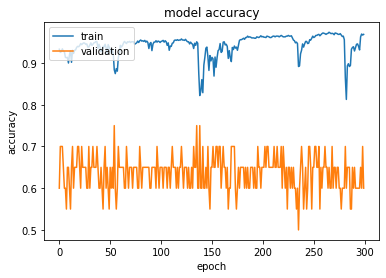

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


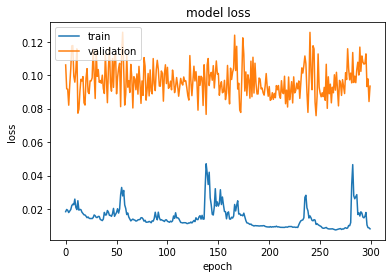

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()